In [18]:
import pandas as pd
import numpy as np

df_ekar = pd.read_csv("ekar.txt", sep="\t", decimal=',')
df_ekar['Date'] = pd.to_datetime(df_ekar['Date'], dayfirst=True)
df_ekar.set_index('Date', inplace=True)
display(df_ekar.head(5))

df_oulu = pd.read_csv("oulu.txt", sep="\t", decimal=',')
df_oulu['Date'] = pd.to_datetime(df_oulu['Date'])
df_oulu.set_index('Date', inplace=True)
display(df_oulu.head(5))

,Temp,Press,Counts,PCC,Err PCC,PTCC,Err PTCC
Date,,,,,,,
2026-01-17 08:00:00,19.0,869.39,13933,14067.19,119.17,14164.65,118.48
2026-01-17 09:00:00,19.3,869.71,14063,14206.52,119.19,14311.81,118.49
2026-01-17 10:00:00,19.3,869.93,14045,14193.89,119.18,14299.09,118.49
2026-01-17 11:00:00,19.5,869.65,13772,13911.07,119.16,14018.65,118.47
2026-01-17 12:00:00,19.7,869.24,13833,13962.50,119.16,14074.98,118.48


,Counts
Date,
2026-01-17 08:00:00,91.601
2026-01-17 08:01:00,91.659
2026-01-17 08:02:00,93.146
2026-01-17 08:03:00,93.522
2026-01-17 08:04:00,90.798


In [19]:
# scelgo i conteggi da utilizzare PTCC (Pressure Temperature Corrected Counts)
ekar_counts = 'PTCC'

# scalo EKAR a conteggi al minuto dato che integra 1h
df_ekar[ekar_counts] /= 60

# scalo OULU a conteggi al minuto dato che riporta conteggi al secondo
df_oulu['Counts'] *= 60

# coefficente per scalare i conteggi di OULU a quelli di EKAR
k = df_ekar['PTCC'].mean() / df_oulu['Counts'].mean()

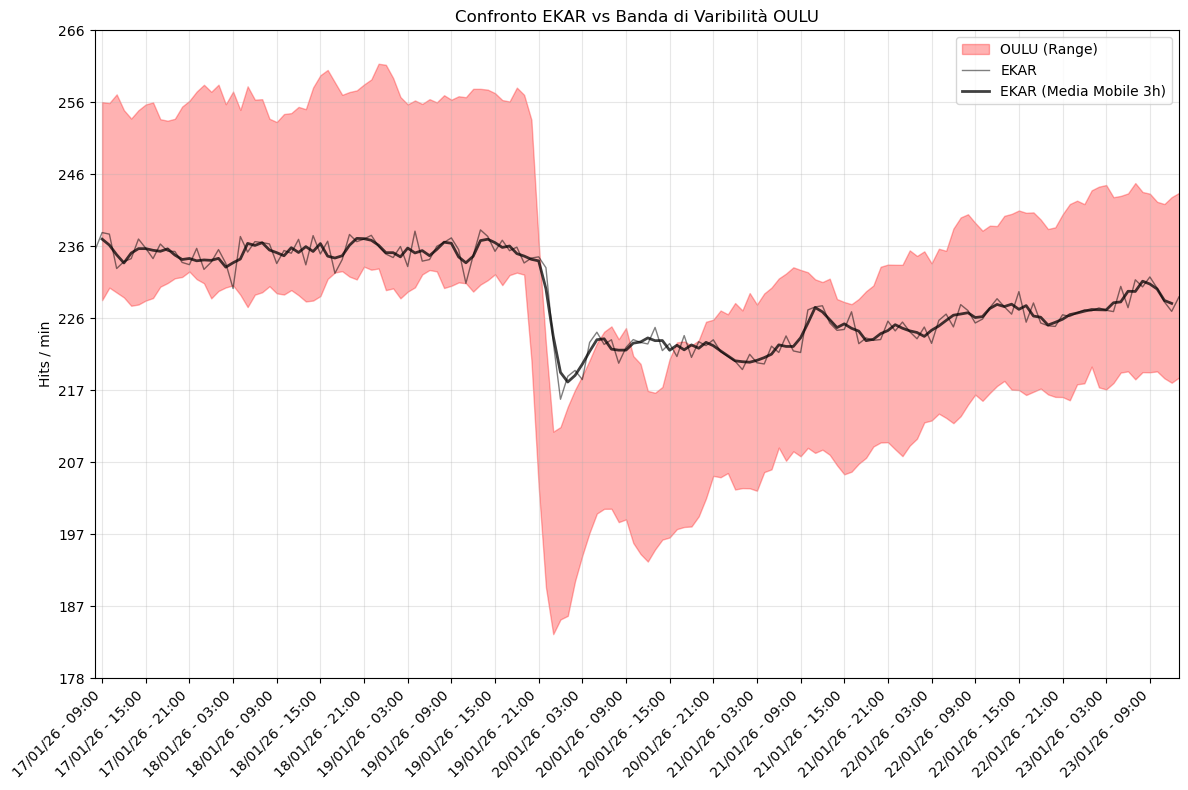

In [20]:
# 1. Preparazione OULU (Banda di riferimento)
# Calcoliamo min, max e media oraria per definire la banda

oulu_stats = df_oulu['Counts'].resample('1h').agg(['min', 'max', 'mean'])
oulu_stats = oulu_stats.rolling(window=3, center=True).mean()
oulu_scaled = oulu_stats * k

# 2. Preparazione EKAR (Segnale + Smoothing)
# Calcoliamo una media mobile di 3 ore per vedere il trend al netto del rumore
ekar_smooth = df_ekar[ekar_counts].rolling(window=3, center=True).mean()

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
# 3. Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# A. Banda OULU (La referenza fisica)
ax.fill_between(oulu_scaled.index, 
                oulu_scaled['min'], 
                oulu_scaled['max'], 
                color='red', alpha=0.3, label='OULU (Range)')

# B. EKAR Raw (Dati grezzi) - Lo facciamo grigio chiaro o sottile
ax.plot(df_ekar.index, df_ekar[ekar_counts], color='black', alpha=0.5, lw=1, label='EKAR')

# C. EKAR Smooth (Trend) - Questo è quello che devi confrontare con la banda rossa
ax.plot(df_ekar.index, ekar_smooth, color='black', lw=2, alpha=0.75, label='EKAR (Media Mobile 3h)')

ax.set_title(f"Confronto EKAR vs Banda di Varibilità OULU")
ax.set_ylabel("Hits / min")
ax.legend()
ax.grid(True, alpha=0.3)

t_start = pd.Timestamp("2026-01-17 08:00:00")
t_end   = pd.Timestamp("2026-01-23 13:00:00")
ax.set_xlim(t_start, t_end)

start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(round(start-2,0), round(end+1,0), 10))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y - %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

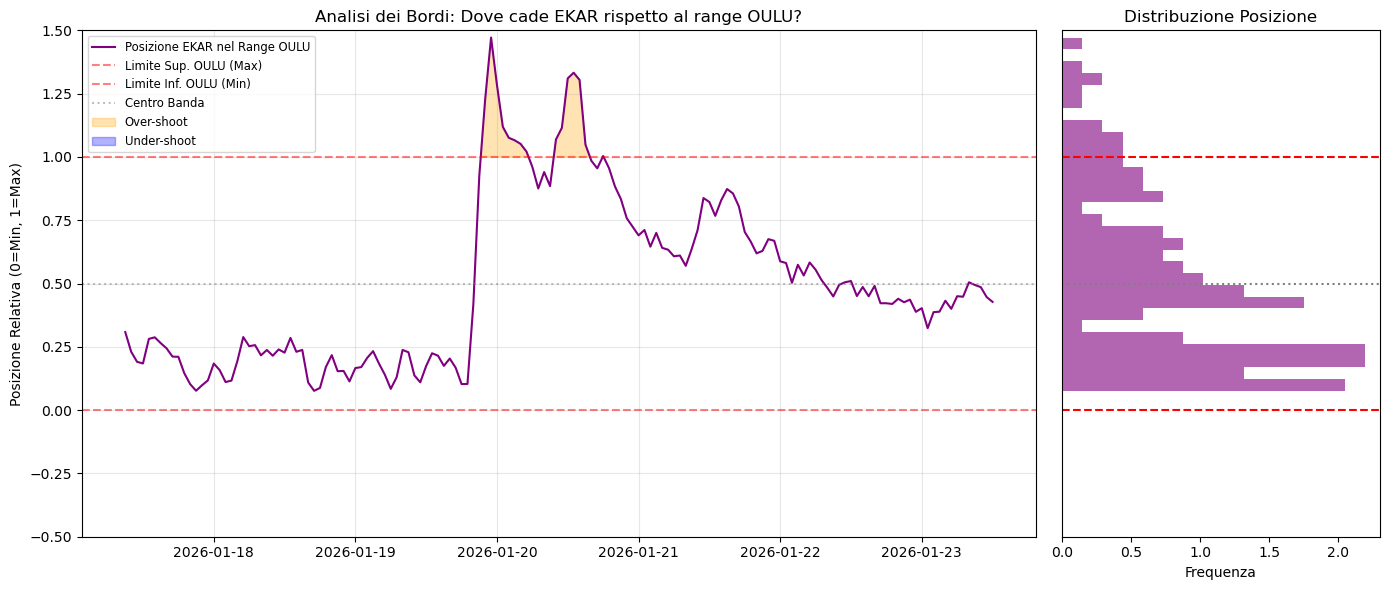

In [21]:
# --- Assumiamo che le variabili oulu_scaled (DataFrame con min, max) 
# --- e ekar_smooth (Series) siano già calcolate come nello step precedente ---

# 1. Calcolo del Posizionamento Relativo (Score P)
# Allineiamo gli indici per sicurezza
common_index = oulu_scaled.index.intersection(ekar_smooth.index)
oulu_aligned = oulu_scaled.loc[common_index]
ekar_aligned = ekar_smooth.loc[common_index]

# Calcoliamo l'ampiezza della banda OULU in ogni istante
band_width = oulu_aligned['max'] - oulu_aligned['min']

# Calcoliamo dove cade EKAR in percentuale rispetto al min e max di OULU
# P = (EKAR - Min) / (Max - Min)
relative_position = (ekar_aligned - oulu_aligned['min']) / band_width

# 2. Plotting (Due pannelli: Time Series + Istogramma)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [3, 1]})

# --- Pannello 1: Evoluzione Temporale ---
ax1.plot(relative_position.index, relative_position, color='purple', lw=1.5, label='Posizione EKAR nel Range OULU')

# Disegniamo i bordi della banda OULU (che ora sono le linee 0 e 1)
ax1.axhline(1, color='red', linestyle='--', alpha=0.5, label='Limite Sup. OULU (Max)')
ax1.axhline(0, color='red', linestyle='--', alpha=0.5, label='Limite Inf. OULU (Min)')
ax1.axhline(0.5, color='gray', linestyle=':', alpha=0.5, label='Centro Banda')

# Evidenziamo le aree "Fuori Banda"
ax1.fill_between(relative_position.index, 1, relative_position, 
                 where=(relative_position > 1), color='orange', alpha=0.3, interpolate=True, label='Over-shoot')
ax1.fill_between(relative_position.index, 0, relative_position, 
                 where=(relative_position < 0), color='blue', alpha=0.3, interpolate=True, label='Under-shoot')

ax1.set_title("Analisi dei Bordi: Dove cade EKAR rispetto al range OULU?")
ax1.set_ylabel("Posizione Relativa (0=Min, 1=Max)")
ax1.set_ylim(-0.5, 1.5) # Lasciamo spazio per vedere gli "sforamenti"
ax1.legend(loc='upper left', fontsize='small')
ax1.grid(True, alpha=0.3)

# --- Pannello 2: Distribuzione (Istogramma) ---
# Questo risponde alla domanda: "EKAR sta più spesso vicino al bordo sopra o sotto?"
ax2.hist(relative_position.dropna(), bins=30, orientation='horizontal', color='purple', alpha=0.6, density=True)
ax2.axhline(1, color='red', linestyle='--')
ax2.axhline(0, color='red', linestyle='--')
ax2.axhline(0.5, color='gray', linestyle=':')
ax2.set_title("Distribuzione Posizione")
ax2.set_xlabel("Frequenza")
ax2.set_ylim(-0.5, 1.5) # Stesso asse Y del grafico a sx
ax2.set_yticks([]) # Nascondiamo i tick Y perché sono condivisi

plt.tight_layout()
plt.show()

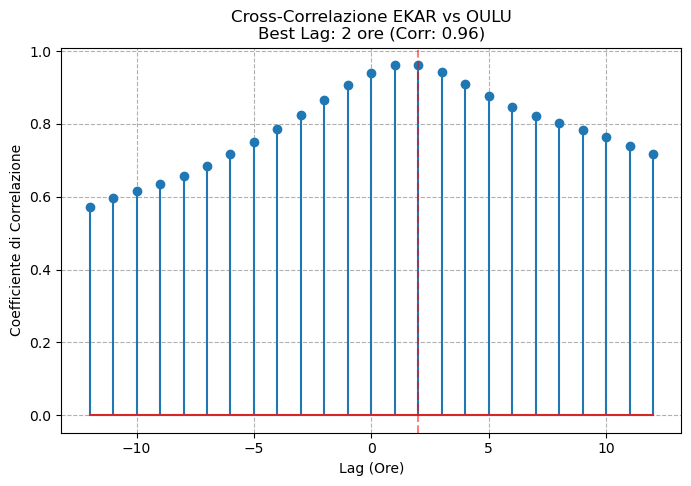

Risultato: Il segnale EKAR ha la massima somiglianza con OULU con uno sfasamento di 2 ore.


In [22]:
# 1. Preparazione delle serie (Rimuoviamo i NaN per il calcolo)
# Usiamo i dati orari perché su quelli al minuto il rumore è troppo alto
# EKAR (smoothed) vs OULU (mean)
s1 = ekar_smooth.dropna() # EKAR (Il segnale "test")
s2 = oulu_scaled['mean'].dropna() # OULU (Il segnale "riferimento")

# Allineiamo sugli indici comuni
common_idx = s1.index.intersection(s2.index)
s1 = s1.loc[common_idx]
s2 = s2.loc[common_idx]

# Normalizziamo (Z-score) per confrontare solo le forme d'onda
s1_norm = (s1 - s1.mean()) / s1.std()
s2_norm = (s2 - s2.mean()) / s2.std()

# 2. Calcolo Cross-Correlazione
# Cerchiamo un lag tra -12 ore e +12 ore
lags = np.arange(-12, 13) 
correlations = []

for lag in lags:
    # Shiftiamo s2 (OULU) e vediamo quanto assomiglia a s1 (EKAR)
    # Se lag è positivo, stiamo spostando OULU in avanti (vediamo se EKAR è in ritardo)
    corr = s1_norm.corr(s2_norm.shift(lag))
    correlations.append(corr)

# Troviamo il lag migliore
best_lag = lags[np.argmax(correlations)]
max_corr = max(correlations)

# 3. Plotting
fig, ax = plt.subplots(figsize=(8, 5))
ax.stem(lags, correlations)
ax.set_xlabel("Lag (Ore)")
ax.set_ylabel("Coefficiente di Correlazione")
ax.set_title(f"Cross-Correlazione EKAR vs OULU\nBest Lag: {best_lag} ore (Corr: {max_corr:.2f})")
ax.grid(True, linestyle='--')

# Evidenziamo il picco
ax.axvline(best_lag, color='red', linestyle='--', alpha=0.5)

plt.show()

print(f"Risultato: Il segnale EKAR ha la massima somiglianza con OULU con uno sfasamento di {best_lag} ore.")

Statistiche di Conformità (EKAR vs OULU):
 - EKAR fuori dal 'core' (IQR): 69.1% del tempo
 - EKAR fuori dagli estremi (Min-Max): 10.7% del tempo


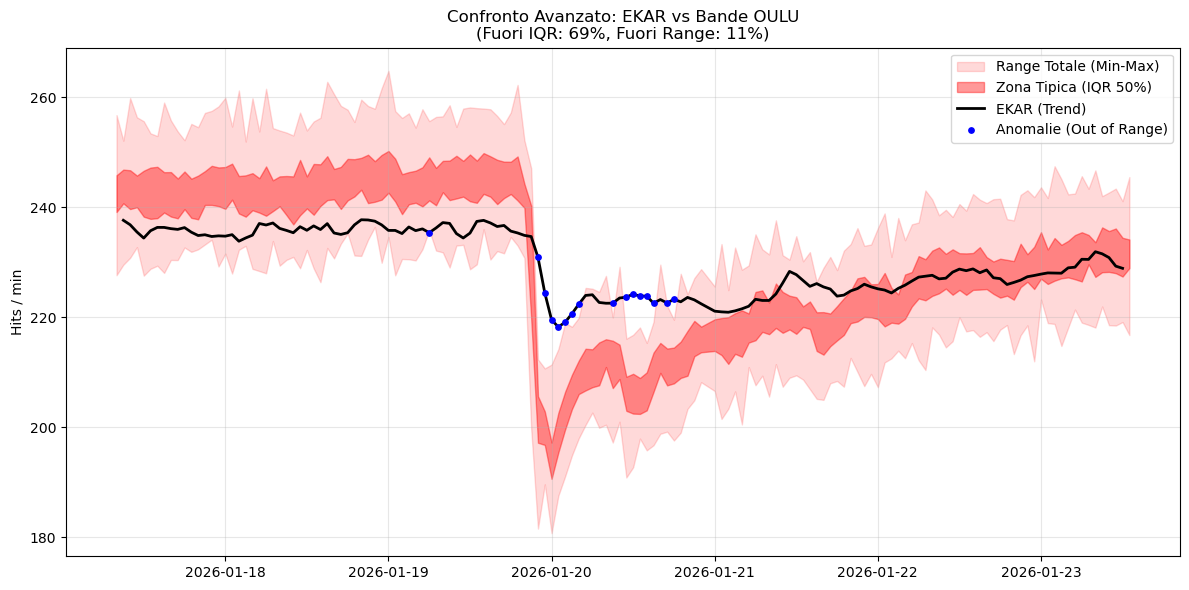

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Preparazione delle Bande di OULU ---
# Calcoliamo 4 metriche per ogni ora: Min, Max, 25% (Q1), 75% (Q3)
# lambda x: x.quantile(...) serve perché 'quantile' non è una funzione stringa standard per agg
oulu_stats = df_oulu['Counts'].resample('1h').agg([
    'min', 
    'max', 
    lambda x: x.quantile(0.25), 
    lambda x: x.quantile(0.75)
])
# Rinominiamo le colonne dei quantili per comodità
oulu_stats.columns = ['min', 'max', 'q25', 'q75']

# Scaliamo tutto con K
oulu_scaled = oulu_stats * k

# Allineiamo EKAR (usiamo la media mobile come riferimento principale)
# Assicuriamoci che gli indici coincidano
common_idx = oulu_scaled.index.intersection(ekar_smooth.index)
oulu_final = oulu_scaled.loc[common_idx]
ekar_final = ekar_smooth.loc[common_idx]

# --- 2. Calcolo Statistiche "Out of Band" ---
# Quante volte EKAR esce dal "cuore" (IQR) di OULU?
is_out_iqr = (ekar_final < oulu_final['q25']) | (ekar_final > oulu_final['q75'])
pct_out_iqr = is_out_iqr.mean() * 100

# Quante volte EKAR esce dal range totale (Min-Max)?
is_out_total = (ekar_final < oulu_final['min']) | (ekar_final > oulu_final['max'])
pct_out_total = is_out_total.mean() * 100

print(f"Statistiche di Conformità (EKAR vs OULU):")
print(f" - EKAR fuori dal 'core' (IQR): {pct_out_iqr:.1f}% del tempo")
print(f" - EKAR fuori dagli estremi (Min-Max): {pct_out_total:.1f}% del tempo")

# --- 3. Plotting "Fan Chart" ---
fig, ax = plt.subplots(figsize=(12, 6))

# A. Banda Totale (Min-Max) - Colore chiaro, sfondo
ax.fill_between(oulu_final.index, 
                oulu_final['min'], 
                oulu_final['max'], 
                color='red', alpha=0.15, label='Range Totale (Min-Max)')

# B. Banda Centrale (IQR) - Colore più scuro, il "cuore"
ax.fill_between(oulu_final.index, 
                oulu_final['q25'], 
                oulu_final['q75'], 
                color='red', alpha=0.4, label='Zona Tipica (IQR 50%)')

# C. EKAR (Media Mobile)
ax.plot(ekar_final.index, ekar_final, color='black', lw=2, label='EKAR (Trend)')

# (Opzionale) Evidenziare i punti dove EKAR esce dal Min-Max
outliers = ekar_final[is_out_total]
ax.scatter(outliers.index, outliers, color='blue', s=15, zorder=5, label='Anomalie (Out of Range)')

ax.set_title(f"Confronto Avanzato: EKAR vs Bande OULU\n(Fuori IQR: {pct_out_iqr:.0f}%, Fuori Range: {pct_out_total:.0f}%)")
ax.set_ylabel("Hits / min")
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

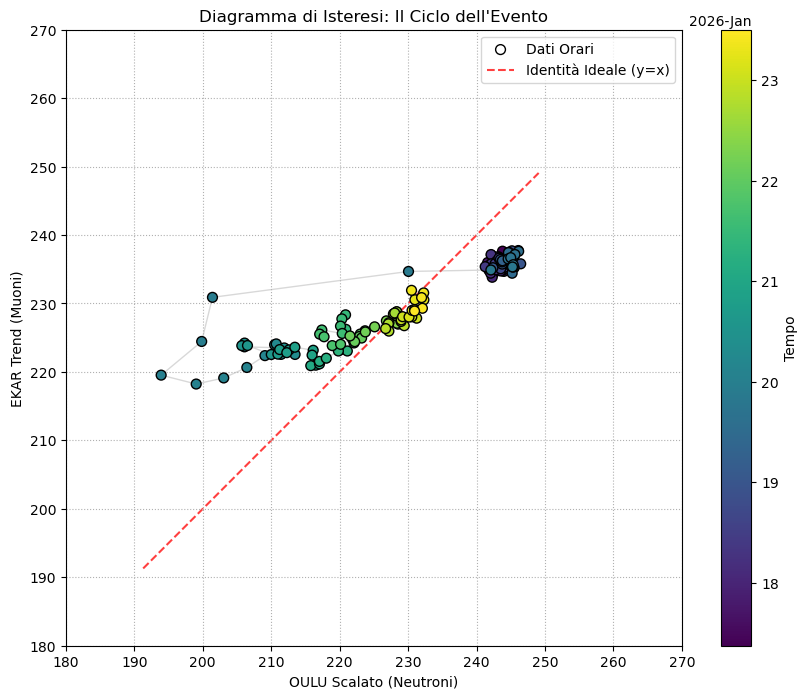

In [24]:

# --- Preparazione Dati ---
# Usiamo i dati orari allineati che hai già usato per il Fan Chart
# OULU (asse X): Usiamo la media oraria scalata
x_val = oulu_final['q25'] + (oulu_final['q75'] - oulu_final['q25'])/2 # Approssimazione mediana o media
# EKAR (asse Y): Usiamo il trend smoothed
y_val = ekar_final

# Creiamo una mappa di colori basata sul tempo per vedere l'evoluzione
# Convertiamo le date in numeri per il colormap
times = mdates.date2num(x_val.index)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot con linea collegata per mostrare la traiettoria
sc = ax.scatter(x_val, y_val, c=times, cmap='viridis', s=50, edgecolors='k', zorder=10, label='Dati Orari')
# Aggiungiamo una linea sottile per mostrare l'ordine temporale
ax.plot(x_val, y_val, color='gray', alpha=0.3, lw=1, zorder=1)

# Aggiungiamo la linea di identità ideale (y=x)
# Poiché abbiamo scalato OULU con K, se fossero identici starebbero sulla bisettrice
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Identità Ideale (y=x)')

# Decorazioni
ax.set_aspect('equal') # Importante per non distorcere il loop
ax.set_xlim(180, 270) # Adatta questi limiti ai tuoi dati se necessario
ax.set_ylim(180, 270)

# Formattazione Colorbar con date leggibili
cbar = plt.colorbar(sc, ax=ax)
loc = mdates.AutoDateLocator()
cbar.ax.yaxis.set_major_locator(loc)
cbar.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
cbar.set_label('Tempo')

ax.set_xlabel('OULU Scalato (Neutroni)')
ax.set_ylabel('EKAR Trend (Muoni)')
ax.set_title('Diagramma di Isteresi: Il Ciclo dell\'Evento')
ax.legend()
ax.grid(True, linestyle=':')

plt.show()